# CMSC5702 (Advanced Topics in Parallel / Distributed Systems)
# Assignment 1: Parallel Programming with Sobel Filter


## Objective

Apply the Sobel filter for edge detection on **large square grayscale images** using MPI and OpenMP, and compare the performance of shared-memory vs distributed-memory parallelization. Optionally, include a blurring step to reduce noise before applying the Sobel operator.

This assignment allows you to practice:

* Sequential programming
* OpenMP parallelization on shared-memory systems
* MPI parallelization on distributed-memory systems
* Performance measurement, verification, and speedup analysis

---

## Problem Description

The **Sobel filter** computes approximate image gradients to detect edges. For a grayscale image (I):

$$
G_x =
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix} * I, \quad
G_y =
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix} * I
$$

The **gradient magnitude** at each pixel is:

$$
G = \sqrt{G_x^2 + G_y^2}
$$
Optional **blurring step**: compute the local average of pixels in a small neighborhood (e.g., 3×3) before applying the Sobel operator to reduce noise.


# Part 1: Sequential Version

- Implement a standard sequential C program to apply the Sobel operator on a grayscale image.
- If including blurring, apply an average filter first (e.g., 3×3 kernel) before Sobel.


#### Question: Explain the algorithm you implemented and if you applyed blurring, explain the blurring method.

#### Your Answer:

The algorithm I implemented is a two-stage process. It first applies an optional blurring filter to reduce noise and then runs the Sobel operator to detect edges.

I applied blurring using the $3 \times 3$ mean filter method, as suggested in the assignment for the optional bonus. This step is designed to smooth the image and reduce the impact of noise on the final edge detection. The mean_blur function works by iterating over each internal pixel, summing the values of its $3 \times 3$ neighborhood, and then storing the average (sum divided by 9) into an intermediate blurred_image buffer. For simplicity, the 1-pixel border of the image is not processed and is instead copied directly from the original.

After blurring, the sobel_filter function is applied to the blurred_image. This function iterates over each internal pixel and applies the two $3 \times 3$ Sobel convolution kernels, $G_x$ and $G_y$, to calculate the horizontal (sum_x) and vertical (sum_y) gradients, respectively.Finally, the gradient magnitude $G$ for each pixel is calculated using the formula $G = \sqrt{G_x^2 + G_y^2}$. This magnitude, which represents the strength of the edge, is stored in the final output_image. The 1-pixel border of this final output is set to zero, as the Sobel operator cannot be fully computed at the very edge of the image. This entire computation (blur + sobel) is timed, excluding the initial file I/O.

Other design:
* Robust Parameterization: The implementation is highly flexible, supporting command-line arguments for image size (e.g., 256, 4k, 16k) as required by the assignment. 
* Clear Modularity and Extensibility: All logic for I/O, parameter parsing, and memory management is handled in main. The computationally intensive work is isolated in the mean_blur and sobel_filter functions. The design makes the code highly extensible, as the future OpenMP and MPI versions are developed by directly parallelizing these two core functions without altering the main program flow.
* Efficient Loop Design: I designed the loops for better performance. The main loops only process the "internal" pixels, skipping the 1-pixel border. After that, separate, simpler loops handle the border pixels. This design avoids putting if statements inside the main processing loop. It's an optimization because those if branches can interrupt the CPU's flow (pipeline) and make it guess wrong, which slows down the whole calculation.

In [1]:
!pip install pandas

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple


In [2]:
!pip install matplotlib

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

seq_df = pd.read_csv("sequential_times.csv")

In [4]:
seq_df

,image_size,run1_time,run2_time,run3_time
0,256,0.004316,0.005268,0.004518
1,1024,0.069932,0.069235,0.070627
2,4000,1.043042,1.051668,1.044982
3,16000,17.873339,17.922349,17.919953


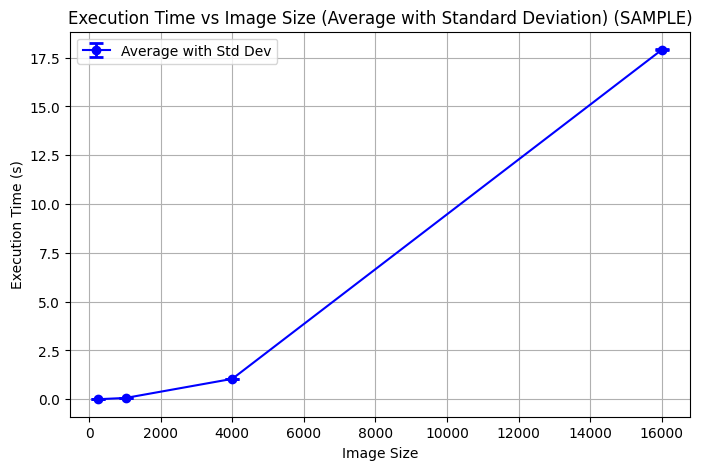

Data with averages and standard deviations:
   image_size  average_time   std_dev
0         256      0.004701  0.000502
1        1024      0.069931  0.000696
2        4000      1.046564  0.004525
3       16000     17.905214  0.027630


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is in a DataFrame called df
# Calculate average and standard deviation
seq_df['average_time'] = seq_df[['run1_time', 'run2_time', 'run3_time']].mean(axis=1)
seq_df['std_dev'] = seq_df[['run1_time', 'run2_time', 'run3_time']].std(axis=1)

# Plot with error bars showing standard deviation
plt.figure(figsize=(8,5))
plt.errorbar(seq_df['image_size'], seq_df['average_time'], 
             yerr=seq_df['std_dev'], 
             marker='o', 
             color='blue', 
             label='Average with Std Dev',
             capsize=5,  # Adds caps to the error bars
             capthick=2,
             elinewidth=2)

plt.xlabel('Image Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Image Size (Average with Standard Deviation) (SAMPLE)')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Print the calculated values
print("Data with averages and standard deviations:")
print(seq_df[['image_size', 'average_time', 'std_dev']])

# Part 2: OpenMP Programming

- Use\#pragma omp parallel for collapse(2) for nested loops.
- Experiment with schedule(static) and other scheduling clauses.
- Process large images in tiles (e.g., 512×512 or 1024×1024) to reduce memory bandwidth issues.
- [Bonus Point] Optionally include a blurring step before the Sobel operator to reduce noise. 


#### Question: Explain the algorithm you implemented and if you applyed blurring, explain the blurring method.

#### Your Answer:

My algorithm is the same two-stage process as the sequential version: it first runs a blur filter and then applies the Sobel operator.

I applied blurring, using the same $3 \times 3$ mean filter method. The mean_blur function smooths the image, and the sobel_filter function then processes this blurred image to calculate the gradient magnitude $G$ using the $G_x$ and $G_y$ kernels.

The key change in this version is the parallelization of both functions using OpenMP. I identified that the main `for` loop in each function (which iterates over the image rows) was the main bottleneck. I used a `#pragma omp parallel for`  directive on these loops to split the work. This effectively implements a row-wise decomposition, allowing multiple threads to process different rows of the image concurrently.

I also chose to use `schedule(static)` . Since every row in the image has the same width, the amount of work for each row is identical. A static schedule is the most efficient choice here because it divides the work evenly among the threads one time at the start, which minimizes the scheduling overhead during the loop's execution.

Finally, I also parallelized the border-handling code at the end of each function. I used `#pragma omp parallel sections` to create two separate tasks: one thread handles the top and bottom rows, while another simultaneously handles the left and right columns.

In [6]:
omp_df = pd.read_csv("openmp_times.csv")

In [7]:
omp_df.head()

,image_size,threads,run1_time,run2_time,run3_time
0,256,1,0.004742,0.005598,0.004868
1,256,2,0.007125,0.007162,0.007124
2,256,4,0.003671,0.003620,0.003662
3,256,8,0.001899,0.001890,0.001885
4,256,16,0.001041,0.001033,0.001009


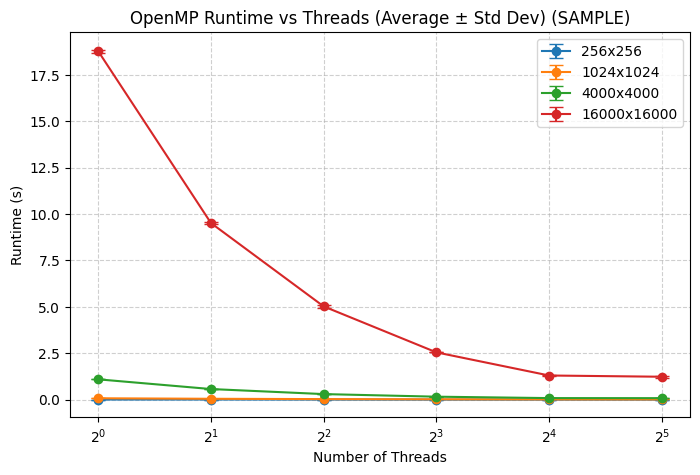

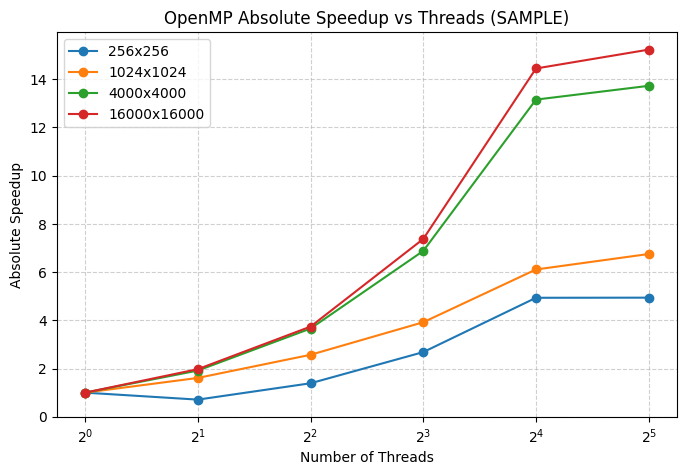

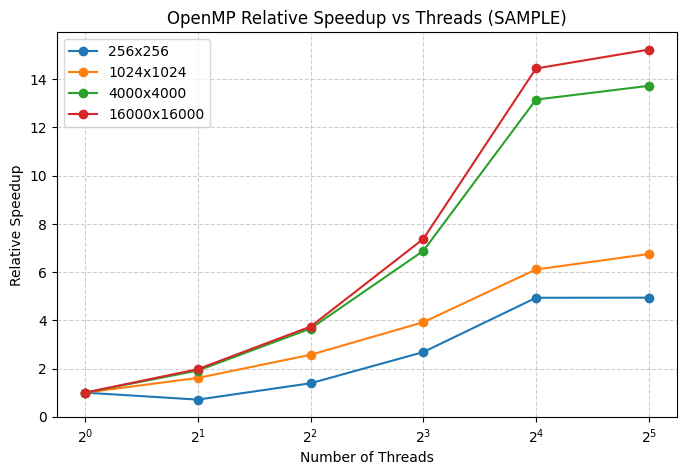

OpenMP data with runtime, std_dev, absolute and relative speedups:
    image_size  threads  average_time   std_dev  absolute_speedup  \
0          256        1      0.005069  0.000462          1.000000   
1          256        2      0.007137  0.000022          0.710289   
2          256        4      0.003651  0.000027          1.388478   
3          256        8      0.001891  0.000007          2.680296   
4          256       16      0.001028  0.000017          4.932858   
5          256       32      0.001027  0.000098          4.937662   
6         1024        1      0.073860  0.000513          1.000000   
7         1024        2      0.045887  0.000536          1.609599   
8         1024        4      0.028749  0.001818          2.569121   
9         1024        8      0.018847  0.000427          3.918978   
10        1024       16      0.012096  0.000284          6.105955   
11        1024       32      0.010945  0.000448          6.748256   
12        4000        1      1.09410

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV if not already loaded
# omp_df = pd.read_csv("openmp_timings.csv")

# 1️⃣ Compute average and standard deviation across runs
omp_df['average_time'] = omp_df[['run1_time','run2_time','run3_time']].mean(axis=1)
omp_df['std_dev'] = omp_df[['run1_time','run2_time','run3_time']].std(axis=1)

# Prepare columns for speedups
omp_df['absolute_speedup'] = 0.0
omp_df['relative_speedup'] = 0.0

# 2️⃣ Compute absolute and relative speedup
# Absolute speedup: vs sequential execution (threads=1)
# Relative speedup: vs OpenMP 1-thread execution (same in this dataset)
for size in omp_df['image_size'].unique():
    # Sequential time (threads=1)
    seq_time = omp_df[(omp_df['image_size']==size) & (omp_df['threads']==1)]['average_time'].values[0]
    
    subset_idx = omp_df[omp_df['image_size']==size].index
    omp_df.loc[subset_idx, 'absolute_speedup'] = seq_time / omp_df.loc[subset_idx, 'average_time']
    omp_df.loc[subset_idx, 'relative_speedup'] = seq_time / omp_df.loc[subset_idx, 'average_time']

# 3️⃣ Plot runtime with error bars
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size']==size]
    plt.errorbar(subset['threads'], subset['average_time'], 
                 yerr=subset['std_dev'], 
                 marker='o', label=f'{size}x{size}', capsize=5)

plt.xlabel('Number of Threads')
plt.ylabel('Runtime (s)')
plt.title('OpenMP Runtime vs Threads (Average ± Std Dev) (SAMPLE)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 4️⃣ Plot absolute speedup
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size']==size]
    plt.plot(subset['threads'], subset['absolute_speedup'], marker='o', label=f'{size}x{size}')

plt.xlabel('Number of Threads')
plt.ylabel('Absolute Speedup')
plt.title('OpenMP Absolute Speedup vs Threads (SAMPLE)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 5️⃣ Plot relative speedup (same as absolute here)
plt.figure(figsize=(8,5))
for size in sorted(omp_df['image_size'].unique()):
    subset = omp_df[omp_df['image_size']==size]
    plt.plot(subset['threads'], subset['relative_speedup'], marker='o', label=f'{size}x{size}')

plt.xlabel('Number of Threads')
plt.ylabel('Relative Speedup')
plt.title('OpenMP Relative Speedup vs Threads (SAMPLE)')
plt.xscale('log', base=2)
plt.xticks([1,2,4,8,16,32])
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 6️⃣ Optional: Print the full dataframe
print("OpenMP data with runtime, std_dev, absolute and relative speedups:")
print(omp_df[['image_size','threads','average_time','std_dev','absolute_speedup','relative_speedup']])


# # Part 3: MPI Programming

- Choose a domain decomposition strategy, such as row-wise decomposition, column-wise decomposition, etc., decomposition. Your choice will affect performance, and better-designed decomposition and communication patterns will receive higher marks.
- For each process, you may need to include some approaches to allow seamless computation for the edges.
- [Bonus Point] You can include If a parallelized blurring step and you may need to try to optimize the communications.
- Verify your implementation using small test patterns (5×5 or 10×10) and visually inspect sample images for correctness.


### My Design:


In [9]:
mpi_df = pd.read_csv("mpi_times.csv")

In [10]:
mpi_df.head()

,image_size,nodes,processes,run1_time,run2_time,run3_time
0,256,1,1,0.005101,0.004047,0.004466
1,256,1,2,0.003155,0.002795,0.002552
2,256,1,4,0.001949,0.001892,0.001953
3,256,4,8,0.001963,0.002087,0.002017
4,256,4,16,0.001577,0.000936,0.001626


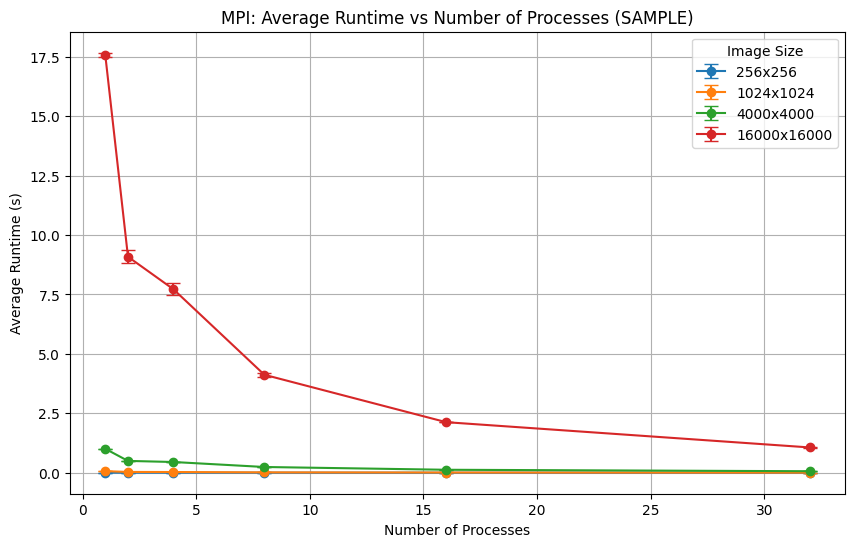

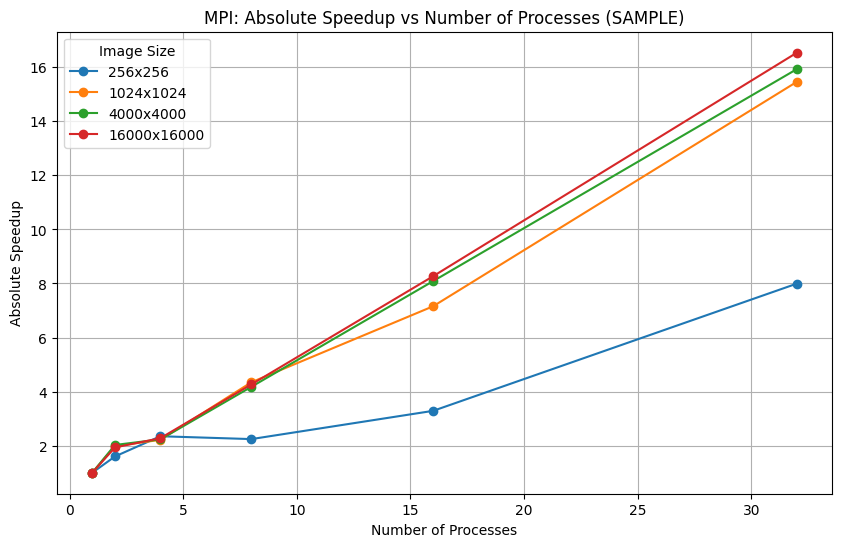

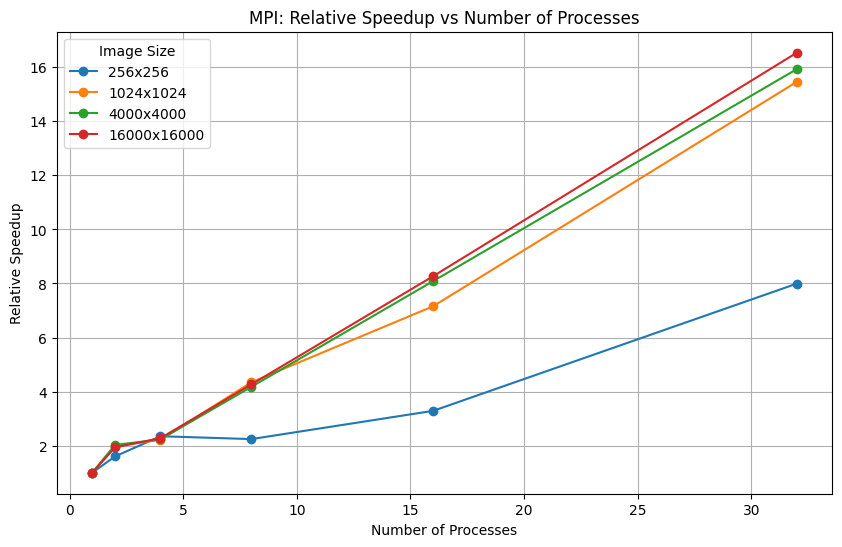

    image_size  nodes  processes  average_time   std_dev  absolute_speedup  \
0          256      1          1      0.004538  0.000531          1.000000   
1          256      1          2      0.002834  0.000303          1.601270   
2          256      1          4      0.001931  0.000034          2.349672   
3          256      4          8      0.002022  0.000062          2.243943   
4          256      4         16      0.001380  0.000385          3.289200   
5          256      4         32      0.000568  0.000336          7.994128   
6         1024      1          1      0.066193  0.000194          1.000000   
7         1024      1          2      0.033371  0.000258          1.983539   
8         1024      1          4      0.029859  0.000980          2.216888   
9         1024      4          8      0.015233  0.000160          4.345486   
10        1024      4         16      0.009248  0.001114          7.157326   
11        1024      4         32      0.004282  0.000153        

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Compute average and standard deviation of runtime
mpi_df['average_time'] = mpi_df[['run1_time', 'run2_time', 'run3_time']].mean(axis=1)
mpi_df['std_dev'] = mpi_df[['run1_time', 'run2_time', 'run3_time']].std(axis=1)

# --- Compute Absolute and Relative Speedup from CSV ---

# Absolute speedup: sequential = 1 process on 1 node
absolute_speedup = {}
for img_size in mpi_df['image_size'].unique():
    # Find sequential runtime: 1 node, 1 process
    seq_time = mpi_df[(mpi_df['image_size']==img_size) & 
                      (mpi_df['nodes']==1) & 
                      (mpi_df['processes']==1)]['average_time'].values[0]
    absolute_speedup[img_size] = seq_time

# Add speedup columns
mpi_df['absolute_speedup'] = mpi_df.apply(lambda row: absolute_speedup[row['image_size']] / row['average_time'], axis=1)

# Relative speedup: 1 process on 1 node runtime as reference
relative_speedup = {}
for img_size in mpi_df['image_size'].unique():
    ref_time = mpi_df[(mpi_df['image_size']==img_size) & 
                      (mpi_df['nodes']==1) & 
                      (mpi_df['processes']==1)]['average_time'].values[0]
    relative_speedup[img_size] = ref_time

mpi_df['relative_speedup'] = mpi_df.apply(lambda row: relative_speedup[row['image_size']] / row['average_time'], axis=1)

# --- Plots ---

# Runtime with error bars
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.errorbar(df_img['processes'], df_img['average_time'], yerr=df_img['std_dev'],
                 marker='o', capsize=5, label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Average Runtime (s)')
plt.title('MPI: Average Runtime vs Number of Processes (SAMPLE)')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# Absolute speedup
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.plot(df_img['processes'], df_img['absolute_speedup'], marker='o', label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Absolute Speedup')
plt.title('MPI: Absolute Speedup vs Number of Processes (SAMPLE)')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# Relative speedup
plt.figure(figsize=(10,6))
for img_size in sorted(mpi_df['image_size'].unique()):
    df_img = mpi_df[mpi_df['image_size']==img_size]
    plt.plot(df_img['processes'], df_img['relative_speedup'], marker='o', label=f'{img_size}x{img_size}')
plt.xlabel('Number of Processes')
plt.ylabel('Relative Speedup')
plt.title('MPI: Relative Speedup vs Number of Processes')
plt.legend(title='Image Size')
plt.grid(True)
plt.show()

# Optional: print dataframe
print(mpi_df[['image_size','nodes','processes','average_time','std_dev','absolute_speedup','relative_speedup']])
